# xT

Used python modules:
```
ipykernel
mplsoccer
statsmodels
joblib
scikit-learn
xgboost
XlsxWriter
```

The wyscoult data can be downloaded from
- players https://figshare.com/ndownloader/files/15073721
- events  https://figshare.com/ndownloader/files/14464685
- matches https://figshare.com/ndownloader/files/14464622
- teams   https://figshare.com/ndownloader/files/15073697

Script assumes the data files the following structure:
```  
Wyscout\events\events_England.json
Wyscout\matches\matches_England.json
Wyscout\players.json
Wyscout\teams.json
xT.ipynb (this file)
```
Please update `data_root` etc if you have another layout.
The script saves some debug file and the trained model to `output_folder`

This first part loads all the data.

In [1]:
cd ~

/Users/jamesdavies


In [2]:
cd soccermatics

/Users/jamesdavies/soccermatics


In [10]:
# Imports and load events

# dataframes
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch

# stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# standard libs
import os, time, pathlib, warnings, itertools, json
from contextlib import redirect_stdout

# Some naming conventions:
# 'df_' is used for dataframes,
# 's_' is used both for series and numpy 1D arrays even though they are different types
# 'mask_' is used for boolean masks

# Descriptions about the events/subevents can be found here:  https://dataglossary.wyscout.com/acceleration/
# Tag ids, labels and descriptions can be found here https://support.wyscout.com/matches-wyid-events
all_wyscout_tags = [
    [101, "goal", "Goal"],
    [102, "own_goal", "Own goal"],
    [301, "assist", "Assist"],
    [302, "keypass", "Key pass"],
    [1901, "counter_attack", "Counter attack"],
    [401, "left", "Left foot"],
    [402, "right", "Right foot"],
    [403, "head_body", "Head/body"],
    [1101, "direct", "Direct"],
    [1102, "indirect", "Indirect"],
    [2001, "dangerous_ball_lost", "Dangerous ball lost"],
    [2101, "blocked", "Blocked"],
    [801, "high", "High"],
    [802, "low", "Low"],
    [1401, "interception", "Interception"],
    [1501, "clearance", "Clearance"],
    [201, "opportunity", "Opportunity"],
    [1301, "feint", "Feint"],
    [1302, "missed ball", "Missed ball"],
    [501, "free_space_r", "Free space right"],
    [502, "free_space_l", "Free space left"],
    [503, "take_on_l", "Take on left"],
    [504, "take_on_r", "Take on right"],
    [1601, "sliding_tackle", "Sliding tackle"],
    [601, "anticipated", "Anticipated"],
    [602, "anticipation", "Anticipation"],
    [1701, "red_card", "Red card"],
    [1702, "yellow_card", "Yellow card"],
    [1703, "second_yellow_card", "Second yellow card"],
    [1201, "gb", "Position: Goal low center"],
    [1202, "gbr", "Position: Goal low right"],
    [1203, "gc", "Position: Goal center"],
    [1204, "gl", "Position: Goal center left"],
    [1205, "glb", "Position: Goal low left"],
    [1206, "gr", "Position: Goal center right"],
    [1207, "gt", "Position: Goal high center"],
    [1208, "gtl", "Position: Goal high left"],
    [1209, "gtr", "Position: Goal high right"],
    [1210, "obr", "Position: Out low right"],
    [1211, "ol", "Position: Out center left"],
    [1212, "olb", "Position: Out low left"],
    [1213, "or", "Position: Out center right"],
    [1214, "ot", "Position: Out high center"],
    [1215, "otl", "Position: Out high left"],
    [1216, "otr", "Position: Out high right"],
    [1217, "pbr", "Position: Post low right"],
    [1218, "pl", "Position: Post center left"],
    [1219, "plb", "Position: Post low left"],
    [1220, "pr", "Position: Post center right"],
    [1221, "pt", "Position: Post high center"],
    [1222, "ptl", "Position: Post high left"],
    [1223, "ptr", "Position: Post high right"],
    [901, "through", "Through"],
    [1001, "fairplay", "Fairplay"],
    [701, "lost", "Lost"],
    [702, "neutral", "Neutral"],
    [703, "won", "Won"],
    [1801, "accurate", "Accurate"],
    [1802, "not_accurate", "Not accurate"],
]


def LoadEvents(file_name, data_folder):
    # first check data folder
    if os.path.exists(f"{data_folder}/{file_name}"):
        file_path = pathlib.Path(f"{data_folder}/{file_name}")
    # otherwise try current folder
    elif os.path.exists(file_name):
        file_path = pathlib.Path(file_name)
    else:
        warnings.warn(f"File {file_name} not found")
        return pd.DataFrame()

    print(f"Reading events from '{file_path}'")
    df = pd.read_json(file_path, encoding="unicode-escape")
    return df

# Create folder where we can store all our generated files
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

current_country = "France"
model_country = "France"
data_root = "Wyscout"
df_events = LoadEvents(f"events_{current_country}.json", f"data/{data_root}")
df_matches = LoadEvents(f"matches_{current_country}.json", f"data/{data_root}")
df_players = LoadEvents("players.json", f"data/{data_root}/")
df_teams = LoadEvents("teams.json", f"data/{data_root}/")

Reading events from 'data/Wyscout/events_France.json'
Reading events from 'data/Wyscout/matches_France.json'
Reading events from 'data/Wyscout/players.json'
Reading events from 'data/Wyscout/teams.json'


### Add labels to events

Annotate the data frame with labels that might be good to have.

In [11]:
def AnnotateEvents(df_in, pitch_dim):
    df = df_in.copy()

    print(f"Annotating events")

    # Annotate with custom columns since it simplifies the analysis
    # All custom columns starts with capital letter to avoid confusion with the original data

    # Alternative eventsec that doesn't reset when there is a new match period
    df["EventSec"] = (
        df.groupby(["matchId", "matchPeriod"]).tail(1)["eventSec"].groupby(df.matchId).shift(1, fill_value=0).groupby(df.matchId).cumsum()
    )
    df["EventSec"] = df.EventSec.bfill() + df.eventSec

    print(f"    Adding some spatial info")
    # Add start/end points and length for convenience

    df["X0"] = df.positions.apply(lambda x: x[0]["x"] * pitch_dim.length / 100)
    df["Y0"] = df.positions.apply(lambda x: x[0]["y"] * pitch_dim.width / 100)
    df["X1"] = df.positions.apply(lambda x: x[-1]["x"] * pitch_dim.length / 100)
    df["Y1"] = df.positions.apply(lambda x: x[-1]["y"] * pitch_dim.width / 100)
    df["C0"] = df.positions.apply(lambda x: abs(pitch_dim.width / 2 - x[0]["y"] * pitch_dim.width / 100))
    df["C1"] = df.positions.apply(lambda x: abs(pitch_dim.width / 2 - x[-1]["y"] * pitch_dim.width / 100))

    df["X0_m1"] = df.groupby("matchId")["X0"].shift(1, fill_value=0)
    df["Y0_m1"] = df.groupby("matchId")["Y0"].shift(1, fill_value=0)
    df["X1_m1"] = df.groupby("matchId")["X1"].shift(1, fill_value=0)
    df["Y1_m1"] = df.groupby("matchId")["Y1"].shift(1, fill_value=0)

    # Patch save attempts so they have valid start points
    df.loc[df.eventName == "Save attempt", "X0"] = df.X1
    df.loc[df.eventName == "Save attempt", "Y0"] = df.Y1
    # Patch shots end points to be at the goal center
    df.loc[df.eventName == "Shot", "X1"] = pitch_dim.length
    df.loc[df.eventName == "Shot", "Y1"] = pitch_dim.width / 2

    df["ActionLength"] = np.sqrt((df.X1 - df.X0) ** 2 + (df.Y1 - df.Y0) ** 2)
    df["ActionAngle"] = np.arctan2(df.Y1 - df.Y0, df.X1 - df.X0)
    df["ActionDuration"] = df.eventSec - df.eventSec.shift(-1, fill_value=0)

    # Move x and y so they are relative to the goal center and store in local series
    # hardcode penalty to be at 11,0
    s_gx = np.where(df.subEventName == "Penalty", 11, pitch_dim.length - df.X0)
    s_gy = np.where(df.subEventName == "Penalty", 0, pitch_dim.width / 2 - df.Y0)

    # Use artctan2 to avoid division by zero
    s_angle = np.arctan2(pitch_dim.goal_width * s_gx, s_gx**2 + s_gy**2 - (pitch_dim.goal_width / 2) ** 2)
    df["Opp_goal_angle"] = np.where(s_angle > 0, s_angle, s_angle + np.pi)
    df["Opp_goal_dist"] = np.sqrt(s_gx**2 + s_gy**2)
    df["Own_goal_dist"] = np.sqrt(df.X0**2 + (df.Y0 - pitch_dim.width / 2) ** 2)

    # Add a bool column for each tag
    print(f"    Adding tag masks")
    df["Tags"] = df.tags.apply(lambda x: [tag["id"] for tag in x])
    tags_to_use = ["goal", "blocked", "keypass", "assist", "accurate", "not_accurate", "interception", "won", "lost", "neutral", "head_body"]
    for tag in all_wyscout_tags:
        if tag[1] not in tags_to_use:
            continue
        tag_id = tag[0]
        tag_str = f"TAG_{tag[1]}"
        df[tag_str] = df.Tags.apply(lambda x: tag_id in x)

    print(f"    Adding Home/Away teams and goals")
    grouped_df = df.groupby("matchId")
    df["HomeTeamId"] = grouped_df["teamId"].transform("first")
    df["AwayTeamId"] = (df.HomeTeamId != df.teamId).astype(int) * df.teamId
    df["AwayTeamId"] = grouped_df["AwayTeamId"].transform("max")
    df["HomeTeamGoals"] = (df["TAG_goal"]) & (df["eventName"] == "Shot") & (df.HomeTeamId == df.teamId)
    df["AwayTeamGoals"] = (df["TAG_goal"]) & (df["eventName"] == "Shot") & (df.AwayTeamId == df.teamId)
    df["HomeTeamGoals"] = grouped_df["HomeTeamGoals"].cumsum()
    df["AwayTeamGoals"] = grouped_df["AwayTeamGoals"].cumsum()

    print(f"    Adding player sequences")
    grouped_team_df = df[df.playerId != 0].groupby(["matchId", "matchPeriod", "teamId"])
    df["PlayerSeqenceId"] = grouped_team_df["playerId"].transform(lambda x: np.add.accumulate(x != x.shift(-1, fill_value=0)).astype(int))
    df["PlayerNextTeamPlayerId"] = grouped_team_df["playerId"].transform(lambda x: x.shift(-1, fill_value=0)).astype(int)
    df["PlayerPrevTeamPlayerId"] = grouped_team_df["playerId"].transform(lambda x: x.shift(1, fill_value=0)).astype(int)

    print(f"    Adding xG")

    def CalcXG(df_sub):
        if len(df_sub) == 0:
            return 0
        model = smf.glm(formula="TAG_goal ~ Opp_goal_dist + Opp_goal_angle", data=df_sub, family=sm.families.Binomial()).fit()
        b = model.params.values
        s_xG = 1 / (1 + np.exp(b[0] + b[1] * df_sub.Opp_goal_dist + b[2] * df_sub.Opp_goal_angle))
        return s_xG

    mask_headers = (df.eventName == "Shot") & (df.TAG_head_body)
    df.loc[mask_headers, "XG"] = CalcXG(df[mask_headers])

    mask_non_headers = (df.eventName == "Shot") & (df.TAG_head_body == False)
    df.loc[mask_non_headers, "XG"] = CalcXG(df[mask_non_headers])

    mask_penalties = df["subEventName"] == "Penalty"
    df.loc[mask_penalties, "XG"] = CalcXG(df[mask_penalties])
    df["XG"] = df["XG"].fillna(0)
    return df


# Num matches to use, set to -1 to use all matches
num_matches = -1
matches = df_events.matchId.unique()[0:num_matches]
df_events = df_events[df_events.matchId.isin(matches)]

# create a pitch dim object for preprocessing but also for making sure all plots are the same
pitch_dim = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68).dim
start = time.time()
df_annotated = AnnotateEvents(df_events, pitch_dim)
print(f"{time.time() - start:.2f} seconds")

Annotating events
    Adding some spatial info
    Adding tag masks
    Adding Home/Away teams and goals
    Adding player sequences
    Adding xG
3.76 seconds


### Create possession chains

Modify `chain_ownership_rewards` and `chain_takeover_force` to create chains that fit your needs.

In [12]:
def CreatePossessionChains(df_in):
    df = df_in.copy()

    # We reward the teams a score depending on the actions in the table
    # The rewards are accumulated and if they reach 4 points we switch ownership for the chain
    chain_ownership_rewards = [
        # [event team reward, other team reward, event, subevent, label (bool)]
        #
        # For these event we will always own the chain
        [4, 0, "Shot", "", ""],
        [4, 0, "Free Kick", "", ""],
        [4, 0, "Offside", "", ""],
        [4, 0, "Pass", "", "TAG_accurate"],
        #
        # We need two of these events in a row to own the chain
        # [0, 2, "Pass", "", "TAG_not_accurate"],
        [2, 0, "Save attempt", "", ""],
        [2, 0, "Others on the ball", "", ""],
        #
        # Duels comes in pairs one for each team so we split them up, but we still want them in the same chain
        [1, 0, "Duel", "", "TAG_won"],
        [0, 1, "Duel", "", "TAG_lost"],
        #
        # Neutral duels are ignored
        # [ 0, 0, "Duel", "", "TAG_neutral"],
    ]

    # We can force a change of ownership
    chain_takeover_force = [
        # [shift (1 = event after, 0= this event, -1= event before), event, subevent, label (bool)]
        [1, "Interruption", "", ""],
        [1, "Foul", "", ""],
        #        [0, "Free Kick", "", ""],
        [1, "Save attempt", "", "TAG_goal"],
    ]

    s_home = np.zeros(len(df))
    s_away = np.zeros(len(df))
    s_event_handled = np.zeros(len(df))
    for c in chain_ownership_rewards:
        mask = df.eventName == c[2]
        if len(c[3]) > 0:
            mask = mask & (df.subEventName == c[3])
        if len(c[4]) > 0:
            mask = mask & (df[c[4]])
        mask = mask & (s_event_handled == 0)
        mask_home = mask & (df.HomeTeamId == df.teamId)
        mask_away = mask & (df.AwayTeamId == df.teamId)
        s_home += mask_home * c[0] + mask_away * c[1]
        s_away += mask_home * c[1] + mask_away * c[0]
        s_event_handled = s_event_handled | mask

    # Generate chain ids for home and away chains, then we group based on chain ids
    s_home_chainId = np.add.accumulate(s_home.astype(bool) != s_home.astype(bool).shift(fill_value=0)).astype(int)
    s_away_chainId = np.add.accumulate(s_away.astype(bool) != s_away.astype(bool).shift(fill_value=0)).astype(int)
    # Group and sum the rewards per chain
    s_home = s_home.groupby(s_home_chainId).transform("sum")
    s_away = s_away.groupby(s_away_chainId).transform("sum")
    # If a team reaches 4 points we claim ownership, 1 for home, and -1 for away
    s_home = np.where(s_home >= 4, 1, 0)
    s_away = np.where(s_away >= 4, -1, 0)
    # Then we add them together and fill the gaps/zeros with the preceding value
    combined = pd.Series(s_home + s_away).replace(0, np.nan).ffill()
    # Then we assign the team ids
    teams = pd.Series(np.where(combined == 1, df.HomeTeamId, df.AwayTeamId)).astype(int)
    df["Possession_TeamId"] = teams

    # Now we geneate chains with 1 where ever we want to force chain start
    # First where we want to force a chain
    s_force = np.zeros(len(df))
    for f in chain_takeover_force:
        f_ = df.eventName == f[1]
        if len(f[2]) > 0:
            f_ = f_ & (df.subEventName == f[2])
        if len(f[3]) > 0:
            f_ = f_ & (df[f[3]])
        s_force += f_.shift(f[0], fill_value=0)
    # Then for each new half/period and whenever team ownership changes
    s_newHalf = df.matchPeriod != df.matchPeriod.shift(fill_value=df.matchPeriod[0])
    s_newTeam = teams != teams.shift(fill_value=teams[0])
    # Add them and accumulate to get series that increases with 1 for every new chain start
    df["Possession_Id"] = np.add.accumulate(s_newTeam | s_newHalf | s_force.astype(bool)).astype(int)

    # Annotate possession chains
    # First track create new columns with the data we want to track
    df["Possession_NumShots"] = df.eventName == "Shot"
    df["Possession_NumPasses"] = (df.eventName == "Pass") & (df.teamId == df.Possession_TeamId) & (df.TAG_accurate)
    df["Possession_HasGoal"] = (df.eventName == "Shot") & (df.TAG_goal)

    # Then group by possession chain and calculate the values
    grouped_df = df.groupby("Possession_Id")
    df["Possession_NumShots"] = grouped_df["Possession_NumShots"].transform("sum")
    df["Possession_NumPasses"] = grouped_df["Possession_NumPasses"].transform("sum")
    df["Possession_HasGoal"] = grouped_df["Possession_HasGoal"].transform("any")

    # Then some we already had but not possession grouped
    df["Possession_NumEvents"] = grouped_df["Possession_Id"].transform("count")
    df["Possession_xG"] = grouped_df["XG"].transform("max")
    df["Possession_ChainTime"] = grouped_df["eventSec"].transform("max") - grouped_df["eventSec"].transform("min")
    return df


start = time.time()
df_possession_chains = CreatePossessionChains(df_annotated)
print(f"{time.time() - start:.2f} seconds")

1.75 seconds


### Investigate labels to use

Optimization terminated successfully.
         Current function value: 0.371209
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     Possession_NumShots   No. Observations:               318317
Model:                           Logit   Df Residuals:                   318313
Method:                            MLE   Df Model:                            3
Date:                 Wed, 09 Oct 2024   Pseudo R-squ.:                -0.06970
Time:                         23:01:39   Log-Likelihood:            -1.1816e+05
converged:                        True   LL-Null:                   -1.1046e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X0             0.0030      0.000      8.230      0.000       0.002       0.004
X1            -0.0089

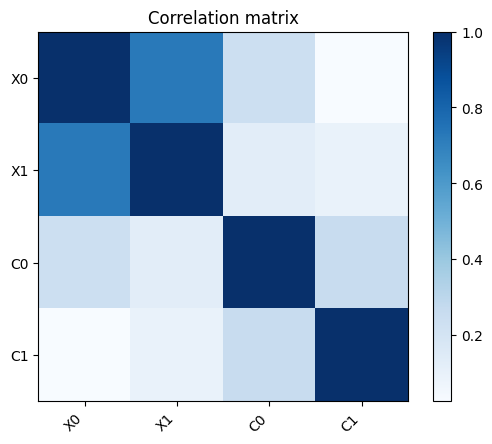

In [13]:
def ShowStatInfo(df, X_vars, y):
    X = df[X_vars]
    log_reg = sm.Logit(y, X).fit()
    print(log_reg.summary())
    matrix = X.corr()
    print(matrix)
    plt.imshow(matrix, cmap="Blues")
    plt.colorbar()
    variables = []
    for i in matrix.columns:
        variables.append(i)
    plt.xticks(range(len(matrix)), variables, rotation=45, ha="right")
    plt.yticks(range(len(matrix)), variables)
    plt.title("Correlation matrix")
    plt.savefig(f"{output_folder}/labels_correlation_matrix.svg")
    plt.show()


df_to_train = df_possession_chains[df_possession_chains.eventName == "Pass"]
X_vars = ["X0", "X1", "C0", "C1"]
y_mask = df_to_train.Possession_NumShots > 0
ShowStatInfo(df_to_train, X_vars, y_mask)

### Train or load model then calculate predictions and xT.

In [14]:
def CalculatePredictions(df_in, X_vars, y_mask):
    # model variables
    from itertools import combinations_with_replacement
    import xgboost
    import joblib
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score

    df = df_in.copy()

    def create_inputs(df_in, var):
        inputs = []
        # one variable combinations
        for i, _ in enumerate(var):
            inputs.extend(combinations_with_replacement(var, i))

        # make new columns
        df = df_in[var].copy()
        columns = {}
        for input in inputs:
            if len(input) <= 1:
                continue
            column_name = ""
            x = pd.Series(1, index=df.index)
            for c in input:
                column_name += c
                x = x * df[c]
            columns[column_name] = x
            var.append(column_name)
        df_dictionary = pd.DataFrame(columns)
        df = pd.concat([df, df_dictionary], axis=1, ignore_index=False)

        # print(df[var[:]].head(3).to_string())
        return df, var

    def train_model_XGB_C(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=y)
        params = dict()
        xgbC = xgboost.XGBClassifier(
            n_estimators=100, ccp_alpha=0, max_depth=4, min_samples_leaf=10, random_state=123
        )  # ,tree_method="hist", device="cuda")
        scores = cross_val_score(estimator=xgbC, X=X_train, y=y_train, cv=10, n_jobs=-1, scoring="roc_auc")
        print(f"ROC AUC. Mean: {np.mean(scores):.2f} Std:{np.std(scores):.2f}")
        xgbC.fit(X_train, y_train)
        print(f"Train score: {xgbC.score(X_train, y_train):.2f}")
        print(f"Test score: {xgbC.score(X_test, y_test):.2f}")
        return xgbC

    def train_model_LinReg(X, y):
        lr = LinearRegression()
        lr.fit(X, y)
        return lr

    df_inputs, var = create_inputs(df, X_vars)

    X = df_inputs.values
    y = y_mask.astype(int).values

    model_filename = f"{output_folder}/{model_country}_shot_prob_model.pkl"
    force_train = True
    if os.path.exists(model_filename) and not force_train:
        print(f"Loading model from {model_filename}")
        model_A = joblib.load(model_filename)
    else:
        if model_country != current_country:
            print(
                f"{model_filename} is missing but required since model country {model_country} is different from current country {current_country}."
            )
        print(f"Training model and saving to {model_filename}")
        model_A = train_model_XGB_C(X, y)
        # model = train_model_LR(X, y)
        #joblib.dump(model_A, model_filename)
    y_pred_proba = model_A.predict_proba(X)[::, 1]
    df["ShotProbability"] = y_pred_proba

    # OLS
    X2 = df_inputs[y_mask].values
    y2 = df[y_mask].Possession_xG.values
    model_B = train_model_LinReg(X2, y2)
    y_pred = model_B.predict(X)
    df["XG_pred"] = y_pred
    df["XT"] = df["XG_pred"] * df["ShotProbability"]
    return df


start = time.time()
df_trained = CalculatePredictions(df_to_train, X_vars, y_mask)
print(f"{time.time() - start:.2f} seconds")
df_trained[["ShotProbability", "XG_pred", "XT"]].head(5)

Training model and saving to outputs/France_shot_prob_model.pkl


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Normalize for possesion and per 90 min

In [ ]:
def PlayerNormalizations(df_players_in, df_matches_in, df_teams, df_events):
    df_players = df_players_in.copy()
    df_matches = df_matches_in.copy()
    matchIds = df_events.matchId.unique()
    df_matches = df_matches.drop(df_matches[~df_matches.wyId.isin(matchIds)].index)
    df_matches["MatchLength"] = df_matches.wyId.map(df_events.groupby(["matchId"]).EventSec.max())

    def ExtractTimes(x, df_events):
        play_time = {}
        matches_played = {}
        possession_owner = {}
        possession_total = {}
        df_me = df_events[df_events.matchId == x.wyId]
        for t in x.teamsData.values():
            players_in = {}
            players_out = {}
            teamId = t["teamId"]
            lineup = t["formation"]["lineup"]
            for p in lineup:
                players_in[p["playerId"]] = 0
                redCard = int(p["redCards"]) * 60
                if redCard >= 1:
                    players_out[p["playerId"]] = redCard
            subs = t["formation"]["substitutions"]
            if subs != "null":
                for s in subs:
                    players_in[s["playerIn"]] = int(s["minute"]) * 60
                    players_out[s["playerOut"]] = int(s["minute"]) * 60
            for p in players_in:
                if not p in players_out:
                    players_out[p] = x.MatchLength
                play_time[p] = players_out[p] - players_in[p]
                df_playerEvents = df_me[(df_me.EventSec >= players_in[p]) & (df_me.EventSec <= players_out[p])]
                df_teamTimes = (
                    df_playerEvents.groupby(["Possession_Id"]).tail(1)["Possession_ChainTime"].groupby([df_playerEvents.Possession_TeamId]).sum()
                )
                possession_owner[p] = df_teamTimes.get(teamId, 0)
                possession_total[p] = df_teamTimes.sum()
        return [play_time, possession_owner, possession_total]

    times = df_matches.apply(lambda x: ExtractTimes(x, df_events), axis=1)

    players = df_events.playerId.unique()
    for p in players:
        if p == 0:
            continue
        player_time = times.apply(lambda x: x[0].get(p, 0)).sum()
        matches_played = times.apply(lambda x: 1 if p in x[0] else 0).sum()
        possession_owner = times.apply(lambda x: x[1].get(p, 0)).sum()
        possession_total = times.apply(lambda x: x[2].get(p, 0)).sum()
        player_row = df_players.loc[df_players.wyId == p].iloc[0]
        df_players.loc[df_players.wyId == p, "TimePlayed"] = (player_time / 60).astype(int)
        df_players.loc[df_players.wyId == p, "MatchesPlayed"] = matches_played.astype(int)
        df_players.loc[df_players.wyId == p, "TotalChainTime"] = possession_total.astype(int)
        df_players.loc[df_players.wyId == p, "OwnerChainTime"] = possession_owner.astype(int)
        df_players.loc[df_players.wyId == p, "NormPer90"] = (90 * 60) / player_time
        df_players.loc[df_players.wyId == p, "NormPossession"] = possession_owner / possession_total

    df_players["TeamName"] = df_players.currentTeamId.map(df_teams.set_index("wyId")["name"]).fillna("Unknown")
    return df_players


start = time.time()
df_players = PlayerNormalizations(df_players, df_matches, df_teams, df_possession_chains)
print(f"{time.time() - start:.2f} seconds")

df_players["XT"] = df_players.wyId.map(df_trained.groupby(["playerId"]).XT.sum())
df_players["XT_normalized"] = df_players["XT"] / df_players["NormPossession"] * df_players["NormPer90"]
vars = ["shortName", "TeamName", "wyId", "XT_normalized", "TimePlayed", "XT", "NormPossession", "NormPer90"]
df_players.loc[df_players.TimePlayed > 400, vars].sort_values(by=["XT_normalized"], ascending=False).head(10)

### Draw one of the chains with the predictions

In [ ]:
def DrawChain(df_in, chain_id, pitch_dim, label):
    mask_chain = (df_in.Possession_Id == chain_id) & (df_in.Possession_TeamId == df_in.teamId)
    df_chain = df_in[mask_chain]
    mask_label = df_chain[label].notna()
    df_label = df_chain[mask_label]
    max_value = df_label[label].max()
    pitch = Pitch(line_color="black", pitch_type=pitch_dim, line_zorder=2)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
    # add size adjusted arrows
    for i, row in df_label.iterrows():
        value = row[label]
        # adjust the line width so that the more passes, the wider the line
        line_width = value / max_value * 10
        # get angle
        # plot lines on the pitch
        pitch.arrows(row.X0, row.Y0, row.X1, row.Y1, alpha=0.6, width=line_width, zorder=2, color="blue", ax=ax["pitch"])
        # annotate text
        ax["pitch"].text(
            (row.X0 + row.X1 - 8) / 2,
            (row.Y0 + row.Y1 - 4) / 2,
            str(value)[:5],
            fontweight="bold",
            color="blue",
            zorder=4,
            fontsize=20,
            rotation=int((row.ActionAngle * 180 / np.pi + 90) % 180 - 90),
        )

    # shot
    shot = df_chain.loc[df_chain.eventName == "Shot"]
    pitch.arrows(shot.X0, shot.Y0, shot.X1, shot.Y1, width=line_width, color="red", ax=ax["pitch"], zorder=3)
    # non lables like arrows
    df_not_label = df_chain.loc[mask_label == False].iloc[:-1]
    pitch.lines(df_not_label.X0, df_not_label.Y0, df_not_label.X1, df_not_label.Y1, color="grey", lw=1.5, ls="dotted", ax=ax["pitch"])
    ax["title"].text(0.5, 0.5, f"Actions leading to a shot with {label}", ha="center", va="center", fontsize=30)
    plt.savefig(f"{output_folder}/chain_{chain_id}_{label}.svg")
    plt.show()


df_possession_chains["XT"] = df_trained["XT"]
df_possession_chains["ShotProbability"] = df_trained["ShotProbability"]
df_possession_chains["XG_pred"] = df_trained["XG_pred"]
DrawChain(df_possession_chains, 5, pitch_dim, "XT")
DrawChain(df_possession_chains, 5, pitch_dim, "ShotProbability")
DrawChain(df_possession_chains, 5, pitch_dim, "XG_pred")

### Dump possesion chains to files

One text file with some chain info.

One excel file with the data frame.

In [ ]:
def DumpPossessionChains(filename, df):
    with open(filename, "w") as f:
        print(f"Dumping possession chains to '{filename}'")
        with redirect_stdout(f):

            def PrintHelp_TagDescs(event):
                r = []
                for tagId in event.tags:
                    r.append([tag[2] for tag in all_wyscout_tags if tag[0] == tagId["id"]][0])
                return sorted(r)

            def PrintHelp_Time(event):
                m, s = divmod(int(event.eventSec), 60)
                h, m = divmod(m, 60)
                return f"{m:02.0f}:{s:02.0f} ({event.matchPeriod})"

            lastId = -1
            for i, event in df.iterrows():
                if event.Possession_Id != lastId:
                    print(f"--- Chain: {event.Possession_Id} Team: {event.Possession_TeamId} ---")
                print(
                    f"[{i:0>{3}}]\t [{PrintHelp_Time(event)}]\t {event.teamId} '{event.eventName}' - '{event.subEventName}' - {PrintHelp_TagDescs(event)}"
                )
                lastId = event.Possession_Id


max_num_output_rows = 10000
df_to_dump = df_possession_chains[:max_num_output_rows]
#DumpPossessionChains(f"{output_folder}/{current_country}_possession_chain.txt", df_to_dump)

#out_excel_file_name = f"{output_folder}/{current_country}_possession_chains.xlsx"
#with pd.ExcelWriter(out_excel_file_name) as writer:
#    print(f"Dumping data frame in excel format to '{out_excel_file_name}'")
 #   columnsToDrop = ["positions", "eventId", "subEventId", "id", "matchId"]
#   df_to_dump.drop(columns=columnsToDrop).to_excel(writer, sheet_name="Alternative", float_format="%.2f", freeze_panes=(1, 1))
 #   for worksheet in writer.sheets.values():
 #       worksheet.autofit()

### Save a summary of the events

Useful to get a quick overview of the events in the dataset.

In [ ]:
def DumpSummaryToFile(file_name):
    df_all_events = LoadEvents(file_name, "Wyscout/events/")
    out_file_name = f"{output_folder}/{file_name[:-len('.json')]}_summary.txt"
    with open(out_file_name, "w") as f:
        print(f"Dumping summary to '{out_file_name}'")
        with redirect_stdout(f):
            print(f"Total number of events in '{file_name}': {len(df_all_events)}")
            # Print the number of events, subevents and tags to get a feeling for the data
            # A bit slow but it's only run once
            print("Number of events, subevents and tags:")
            events = sorted(df_all_events.eventName.unique())
            for event in events:
                df_event = df_all_events[df_all_events.eventName == event]
                print("\n-------------------------------------------------------------")
                print(f"'{event}': {len(df_event)} ({100*len(df_event)/len(df_all_events):.2f}% of all events)")
                sub_events = sorted(df_event.subEventName.unique())
                for sub_event in sub_events:
                    df_sub_event = df_event[df_event.subEventName == sub_event]
                    print(f"    '{sub_event}': {len(df_sub_event)} ({100*len(df_sub_event)/len(df_event):.2f}% of '{event}' events)")
                    for tag in all_wyscout_tags:
                        tag_id = tag[0]
                        mask_tag = df_sub_event.tags.apply(lambda x: tag_id in [tag["id"] for tag in x])
                        num_tags = len(df_sub_event[mask_tag])
                        if num_tags > 0:
                            # Note that an event can have multiple tags or none
                            print(f"        '{tag[2]}': {num_tags} ({100*num_tags/len(df_sub_event):.2f}%)")


DumpSummaryToFile(f"events_{current_country}.json")